## Capstone - Modeling

In [48]:
# Importing packages

import pandas as pd
import numpy as np

import pydicom
from skimage.transform import resize

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
resized_shape = (64, 64)

In [3]:
dataset = pd.read_csv('full_patient_dataset')

In [4]:
dataset.head(5)

,patientId,patient_age,patient_sex,patient_view_position,pixel_rows,pixel_colums,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA,1024,1024,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F,PA,1024,1024,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M,AP,1024,1024,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M,PA,1024,1024,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,32,F,AP,1024,1024,264.0,152.0,213.0,379.0,1,Lung Opacity


In [5]:
dataset.shape

(30227, 12)

In [6]:
patientId = dataset['patientId'][0]

In [7]:
dcm_file = './stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [8]:
# Creating pixel columns 
pixel_labels = []
for i in range(resized_shape[0] * resized_shape[1]):
    pixel_labels.append("pixel"+str(i))
pixel_labels[:10]

['pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9']

In [9]:
%%time

total_images = dataset.shape[0]

#Creating 1 D Array for all the images

pixel_data = []

num = 0

for i in range(dataset.shape[0]):
    patientId = dataset.iloc[i]['patientId']
    dcm_file = './stage_2_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    
    
    #convert the image into a 1 d array of pixels
    
    final_pixel_array = []
    for j in resize(im, resized_shape): 
        final_pixel_array.extend(j)
    pixel_data.append(final_pixel_array)
    
    
    # Stopping when it hits total number of images
    
    num = num + 1
    if num == total_images:
        break

CPU times: user 1h 27min 32s, sys: 7min 47s, total: 1h 35min 20s
Wall time: 2h 40min 51s


## Binary Classification Model

In [10]:
X = pd.DataFrame(data = pixel_data, columns = pixel_labels)

In [11]:
y = dataset['Target']

In [12]:
X.shape , y.shape

((30227, 4096), (30227,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [15]:
X_train_re = X_train.values.reshape(X_train.shape[0], resized_shape[0], resized_shape[1], 1)
X_test_re = X_test.values.reshape(X_test.shape[0], resized_shape[0], resized_shape[1], 1)

In [16]:
%%time

# Initialize Model
model = Sequential()

# First Convolution  Layer 
model.add(Conv2D(filters = 6,
                 kernel_size = 3,
                 activation = 'relu',
                 input_shape = (resized_shape[0], resized_shape[1], 1)
                ))

# Adding pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolutional layer
model.add(Conv2D(filters=16,
                 kernel_size=3,
                 activation='relu'))

# Adding Pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# Dropout
model.add(Dropout(0.5))

# Flatten
model.add(Flatten())

#Third Convoltion Layer
model.add(Dense(512,
                activation='relu'))

# Fourth Convoltion layer
model.add(Dense(128,
                activation='relu'))
# Dropout
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
CPU times: user 164 ms, sys: 115 ms, total: 280 ms
Wall time: 560 ms


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
__________

In [18]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [19]:
%%time
trained_model = model.fit(X_train_re,
                          y_train_c,
                          batch_size = 32,
                          validation_data = (X_test_re, y_test_c),
                          epochs = 20,
                          verbose = 1
                         )

Instructions for updating:
Use tf.cast instead.
Train on 22670 samples, validate on 7557 samples
Epoch 1/20
22670/22670 [==============================] - 56s 2ms/step - loss: 0.5110 - acc: 0.7519 - val_loss: 0.4748 - val_acc: 0.7866
Epoch 2/20
22670/22670 [==============================] - 53s 2ms/step - loss: 0.4793 - acc: 0.7750 - val_loss: 0.4505 - val_acc: 0.7913
Epoch 3/20
22670/22670 [==============================] - 49s 2ms/step - loss: 0.4665 - acc: 0.7805 - val_loss: 0.4441 - val_acc: 0.7960
Epoch 4/20
22670/22670 [==============================] - 49s 2ms/step - loss: 0.4579 - acc: 0.7852 - val_loss: 0.4438 - val_acc: 0.7928
Epoch 5/20
22670/22670 [==============================] - 50s 2ms/step - loss: 0.4489 - acc: 0.7900 - val_loss: 0.4341 - val_acc: 0.7999- loss: 
Epoch 6/20
22670/22670 [==============================] - 50s 2ms/step - loss: 0.4409 - acc: 0.7946 - val_loss: 0.4335 - val_acc: 0.7993
Epoch 7/20
22670/22670 [==============================] - 49s 2ms/step - 

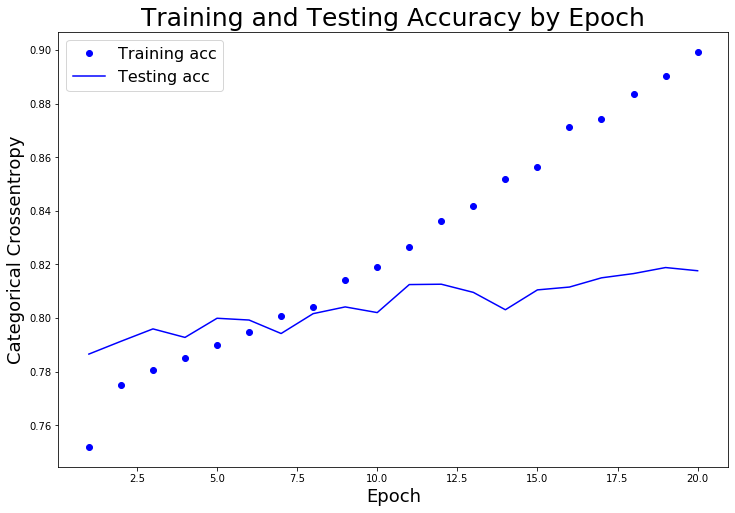

In [41]:
# Ploting Accuracy

plt.figure(figsize=(12, 8))

acc = trained_model.history['acc']
val_acc = trained_model.history['val_acc']

epochs = range(1,len(acc) +1 )

plt.plot(epochs, acc , 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Testing acc')


# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.legend(fontsize = 16)

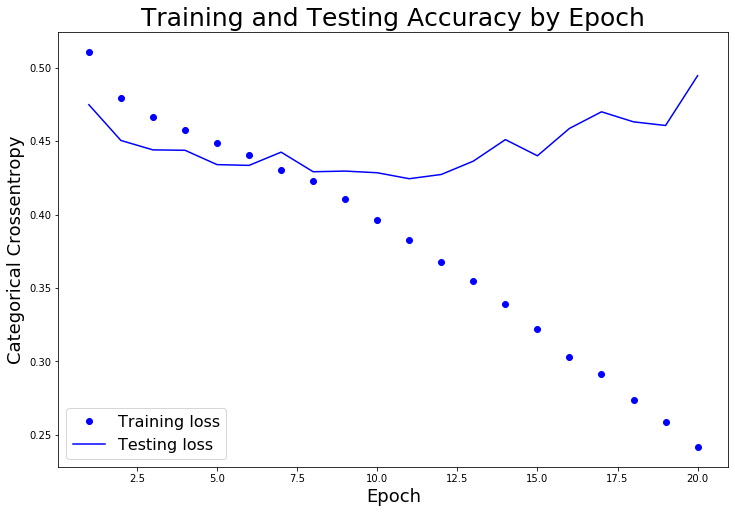

In [42]:
# Plotting Loss
plt.figure(figsize=(12, 8))

loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(1,len(acc) +1 )

plt.plot(epochs, loss , 'bo', label ='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Testing loss')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.legend(fontsize = 16)

In [ ]:
prediction = model_multiclass.predict_classes(X_test_re)
print('Accuracy score :', metrics.accuracy_score(y_test,prediction))

## Multiclass Model

In [22]:
X.shape

(30227, 4096)

In [23]:
dataset['class'].head()

0    No Lung Opacity / Not Normal
1    No Lung Opacity / Not Normal
2    No Lung Opacity / Not Normal
3                          Normal
4                    Lung Opacity
Name: class, dtype: object

In [24]:
label = {'Normal': 0,
         'Lung Opacity': 1,
         'No Lung Opacity / Not Normal':2}

In [25]:
dataset['class'] = dataset['class'].map(label)

In [26]:
dataset['class'].head()

0    2
1    2
2    2
3    0
4    1
Name: class, dtype: int64

In [27]:
dataset['class'].value_counts()

2    11821
1     9555
0     8851
Name: class, dtype: int64

In [28]:
X2 = pd.DataFrame(data = pixel_data, columns = pixel_labels)
y2 = dataset['class']

In [29]:
y2.shape

(30227,)

In [30]:
X2.shape

(30227, 4096)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2,
                                                    stratify=y,
                                                    random_state=42)

In [32]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [33]:
X_train_re = X_train.values.reshape(X_train.shape[0], resized_shape[0], resized_shape[1], 1)
X_test_re = X_test.values.reshape(X_test.shape[0], resized_shape[0], resized_shape[1], 1)

In [34]:
%%time

# Initialize Model
model_multiclass = Sequential()

# First Convolutional Layer 
model_multiclass.add(Conv2D(filters = 6,
                            kernel_size = 3,
                            activation = 'relu',
                            input_shape = (resized_shape[0], resized_shape[1], 1)
                           ))
# pooling
model_multiclass.add(MaxPooling2D(pool_size=(2,2)))

#Second Convolutional layer
model_multiclass.add(Conv2D(filters=16,
                            kernel_size=3,
                            activation='relu'))

# pooling
model_multiclass.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_multiclass.add(Flatten())

# Dropout
model_multiclass.add(Dropout(0.5))

# Third Layer
model_multiclass.add(Dense(512,
                           activation='relu'))

#
model_multiclass.add(Dense(128,
                           activation='relu'))

#Dropout
model_multiclass.add(Dropout(0.5))

# Final 3 output
model_multiclass.add(Dense(3, activation='softmax'))

CPU times: user 110 ms, sys: 52.8 ms, total: 163 ms
Wall time: 220 ms


In [35]:
model_multiclass.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 6)         60        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 16)        880       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1606144   
__________

In [36]:
model_multiclass.compile(loss = 'categorical_crossentropy', 
                         optimizer = 'adam', 
                         metrics = ['accuracy'])

In [38]:
%%time
trained_model_multiclass = model_multiclass.fit(X_train_re,
                                             y_train_c,
                                     batch_size = 32,
                                     validation_data = (X_test_re, y_test_c),
                                     epochs = 20,
                                     verbose = 1
                                    )

Train on 22670 samples, validate on 7557 samples
Epoch 1/20
22670/22670 [==============================] - 55s 2ms/step - loss: 0.9064 - acc: 0.5463 - val_loss: 0.8221 - val_acc: 0.6016
Epoch 2/20
22670/22670 [==============================] - 49s 2ms/step - loss: 0.8367 - acc: 0.6045 - val_loss: 0.7789 - val_acc: 0.6329
Epoch 3/20
22670/22670 [==============================] - 49s 2ms/step - loss: 0.7993 - acc: 0.6249 - val_loss: 0.7619 - val_acc: 0.6443
Epoch 4/20
22670/22670 [==============================] - 51s 2ms/step - loss: 0.7761 - acc: 0.6354 - val_loss: 0.7377 - val_acc: 0.6553
Epoch 5/20
22670/22670 [==============================] - 54s 2ms/step - loss: 0.7551 - acc: 0.6499 - val_loss: 0.7430 - val_acc: 0.6544
Epoch 6/20
22670/22670 [==============================] - 55s 2ms/step - loss: 0.7440 - acc: 0.6566 - val_loss: 0.7259 - val_acc: 0.6643
Epoch 7/20
22670/22670 [==============================] - 52s 2ms/step - loss: 0.7226 - acc: 0.6651 - val_loss: 0.7355 - val_acc:

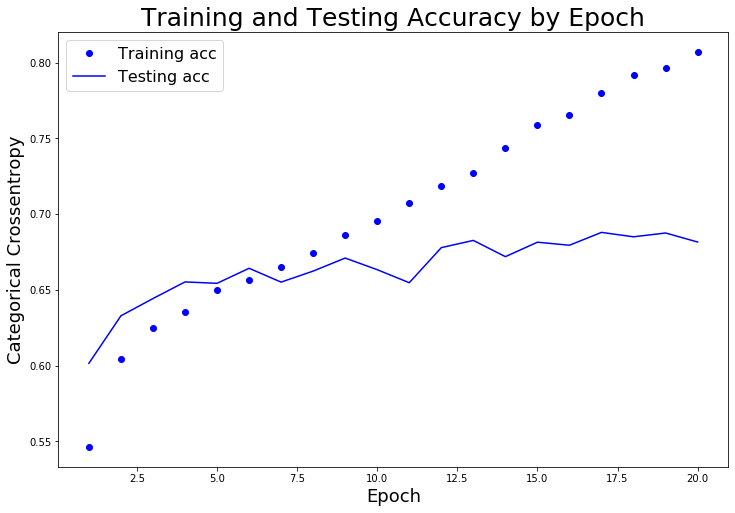

In [45]:
# Ploting Accuracy

plt.figure(figsize=(12, 8))

acc = trained_model_multiclass.history['acc']
val_acc = trained_model_multiclass.history['val_acc']

epochs = range(1,len(acc) +1 )

plt.plot(epochs, acc , 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Testing acc')


# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.legend(fontsize = 16);

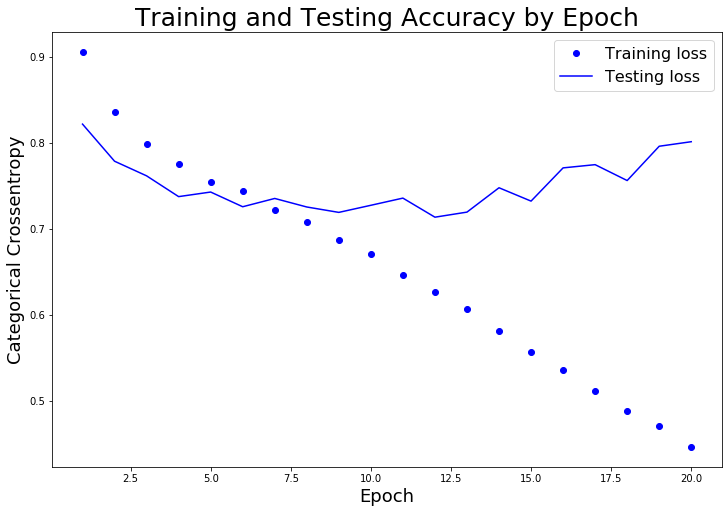

In [44]:
# Plotting Loss
plt.figure(figsize=(12, 8))

loss = trained_model_multiclass.history['loss']
val_loss = trained_model_multiclass.history['val_loss']
epochs = range(1,len(acc) +1 )

plt.plot(epochs, loss , 'bo', label ='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Testing loss')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.legend(fontsize = 16);

In [60]:
prediction = model_multiclass.predict_classes(X_test_re)
print('Accuracy score :', metrics.accuracy_score(y_test,prediction))

Accuracy score : 0.6816196903533148
